## Ames Housing Price Machine Learning Project

### Load necessary packages:

In [30]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from utils import *

#### load sklearn packages
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

### Load necessary files:

- **schoolrank\_**: Tree object, the underlying tree object.

- **ameshpi\_**: The feature importances. The higher, the more important the feature. Also known as gini importance.

- **interest\_**: The feature importances. The higher, the more important the feature. Also known as gini importance.

- **train\_**: The feature importances. The higher, the more important the feature. Also known as gini importance.

- **test\_**: The feature importances. The higher, the more important the feature. Also known as gini importance.

In [49]:
schoolrank = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/xiangwei/data/SchoolRanking.csv')
ameshpi = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/xiangwei/data/ameshpi.csv')
interest = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/xiangwei/data/interest.csv')
train = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/master/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/master/data/test.csv')

### Data Exploration Analysis


- **Missing values** : default=”gini”.
- **Distribution of SalePrice**: default = None.
- **Histograms of numerical variables**: default = 2.
- **Outliers**: default = 1.
- **Correlation Plot**: The number of trees. default=100.

In [10]:
CheckMissing(train)

              Missing Value  Percentage
PoolQC                 1453    0.995205
MiscFeature            1406    0.963014
Alley                  1369    0.937671
Fence                  1179    0.807534
FireplaceQu             690    0.472603
LotFrontage             259    0.177397
GarageYrBlt              81    0.055479
GarageCond               81    0.055479
GarageType               81    0.055479
GarageFinish             81    0.055479
GarageQual               81    0.055479
BsmtFinType2             38    0.026027
BsmtExposure             38    0.026027
BsmtQual                 37    0.025342
BsmtCond                 37    0.025342
BsmtFinType1             37    0.025342
MasVnrArea                8    0.005479
MasVnrType                8    0.005479
Electrical                1    0.000685


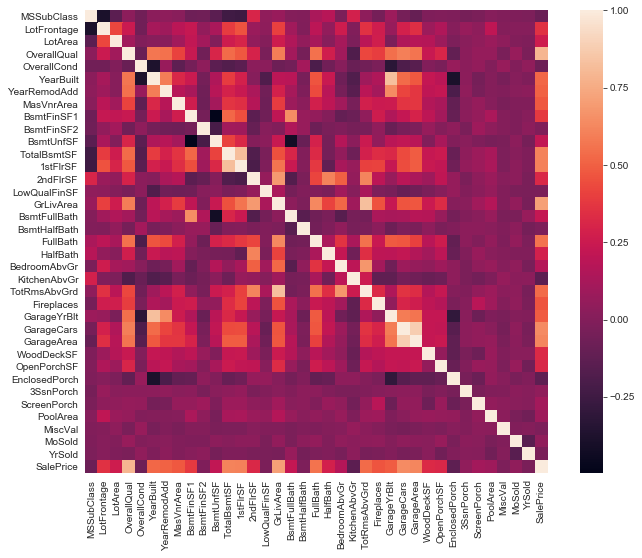

In [22]:
#### look at the correlation heatmap
# train.drop(['Id'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(11.5,8.5))
sns.set_style("white")
sns.heatmap(train.corr(),square=True);
plt.savefig('corrPlot.png',  format='png',transparent=True)

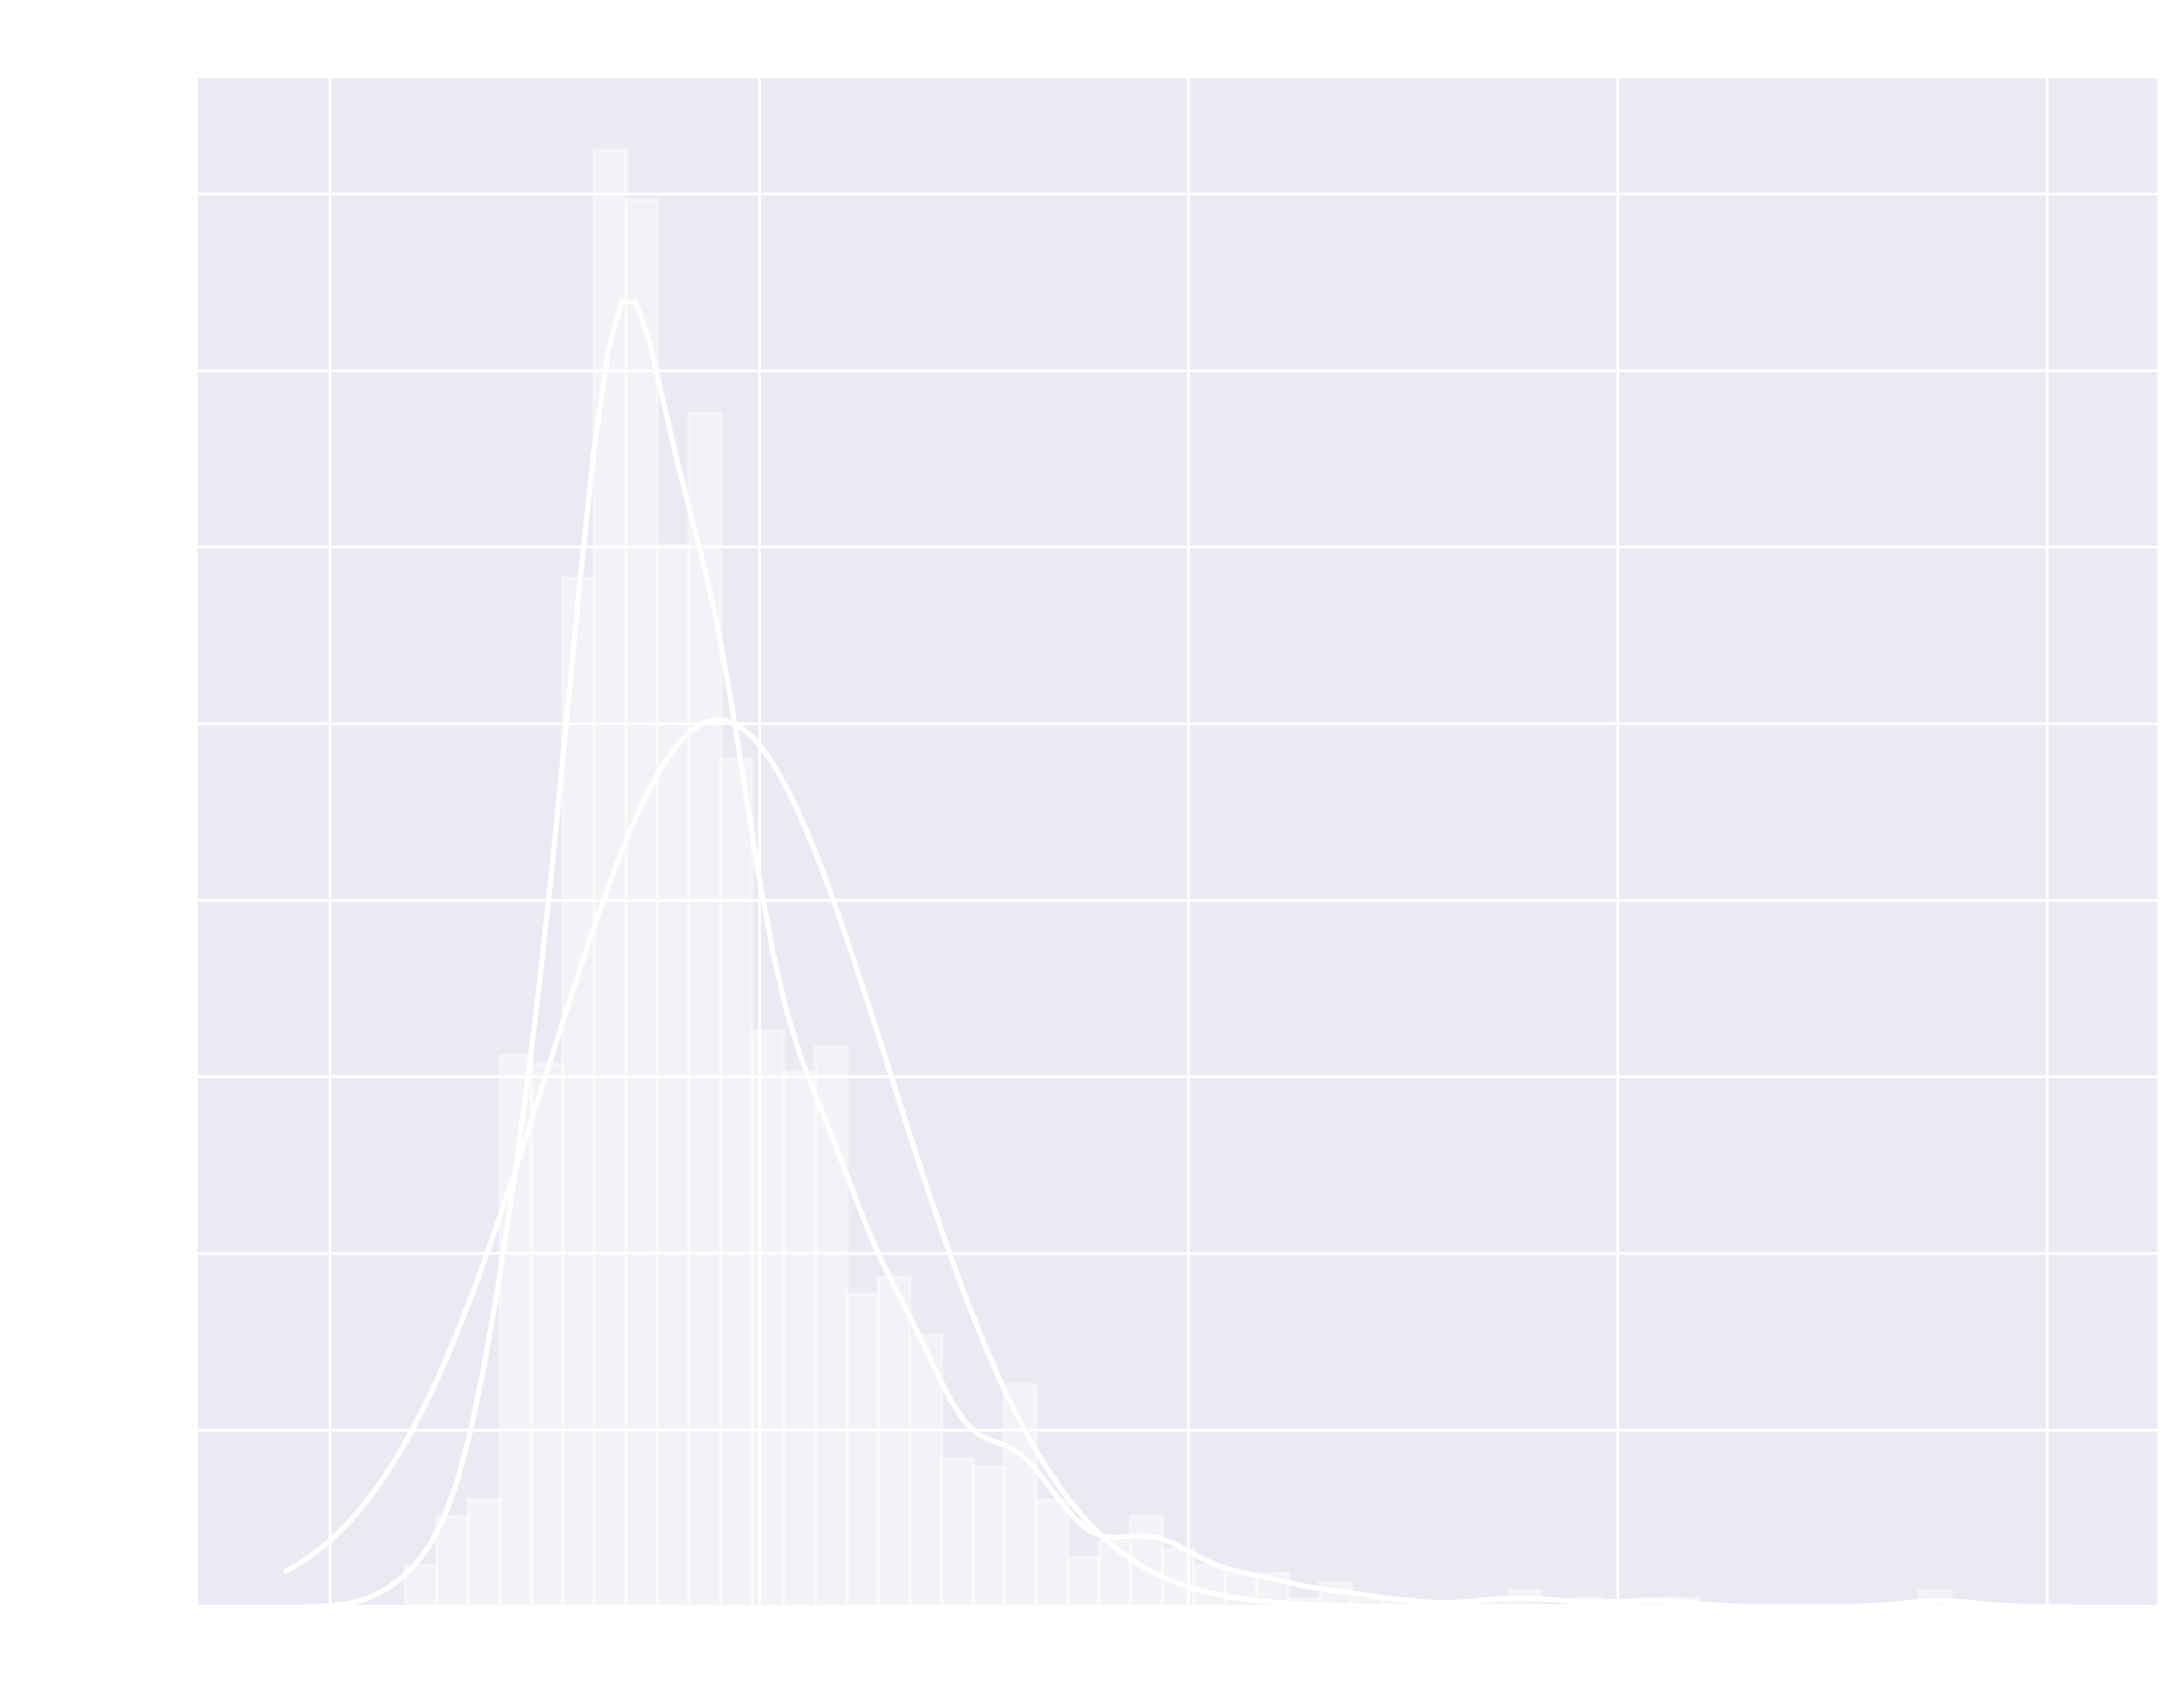

In [45]:
plt.subplots(figsize=(10,8),dpi = 500)
sns.distplot(train['SalePrice'] , color="white", fit=stats.norm, fit_kws={"color":"white"});
plt.title('SalePrice Original', color="white")
plt.xlabel('')
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
plt.savefig('corrPlot.png',  format='png',transparent=True)

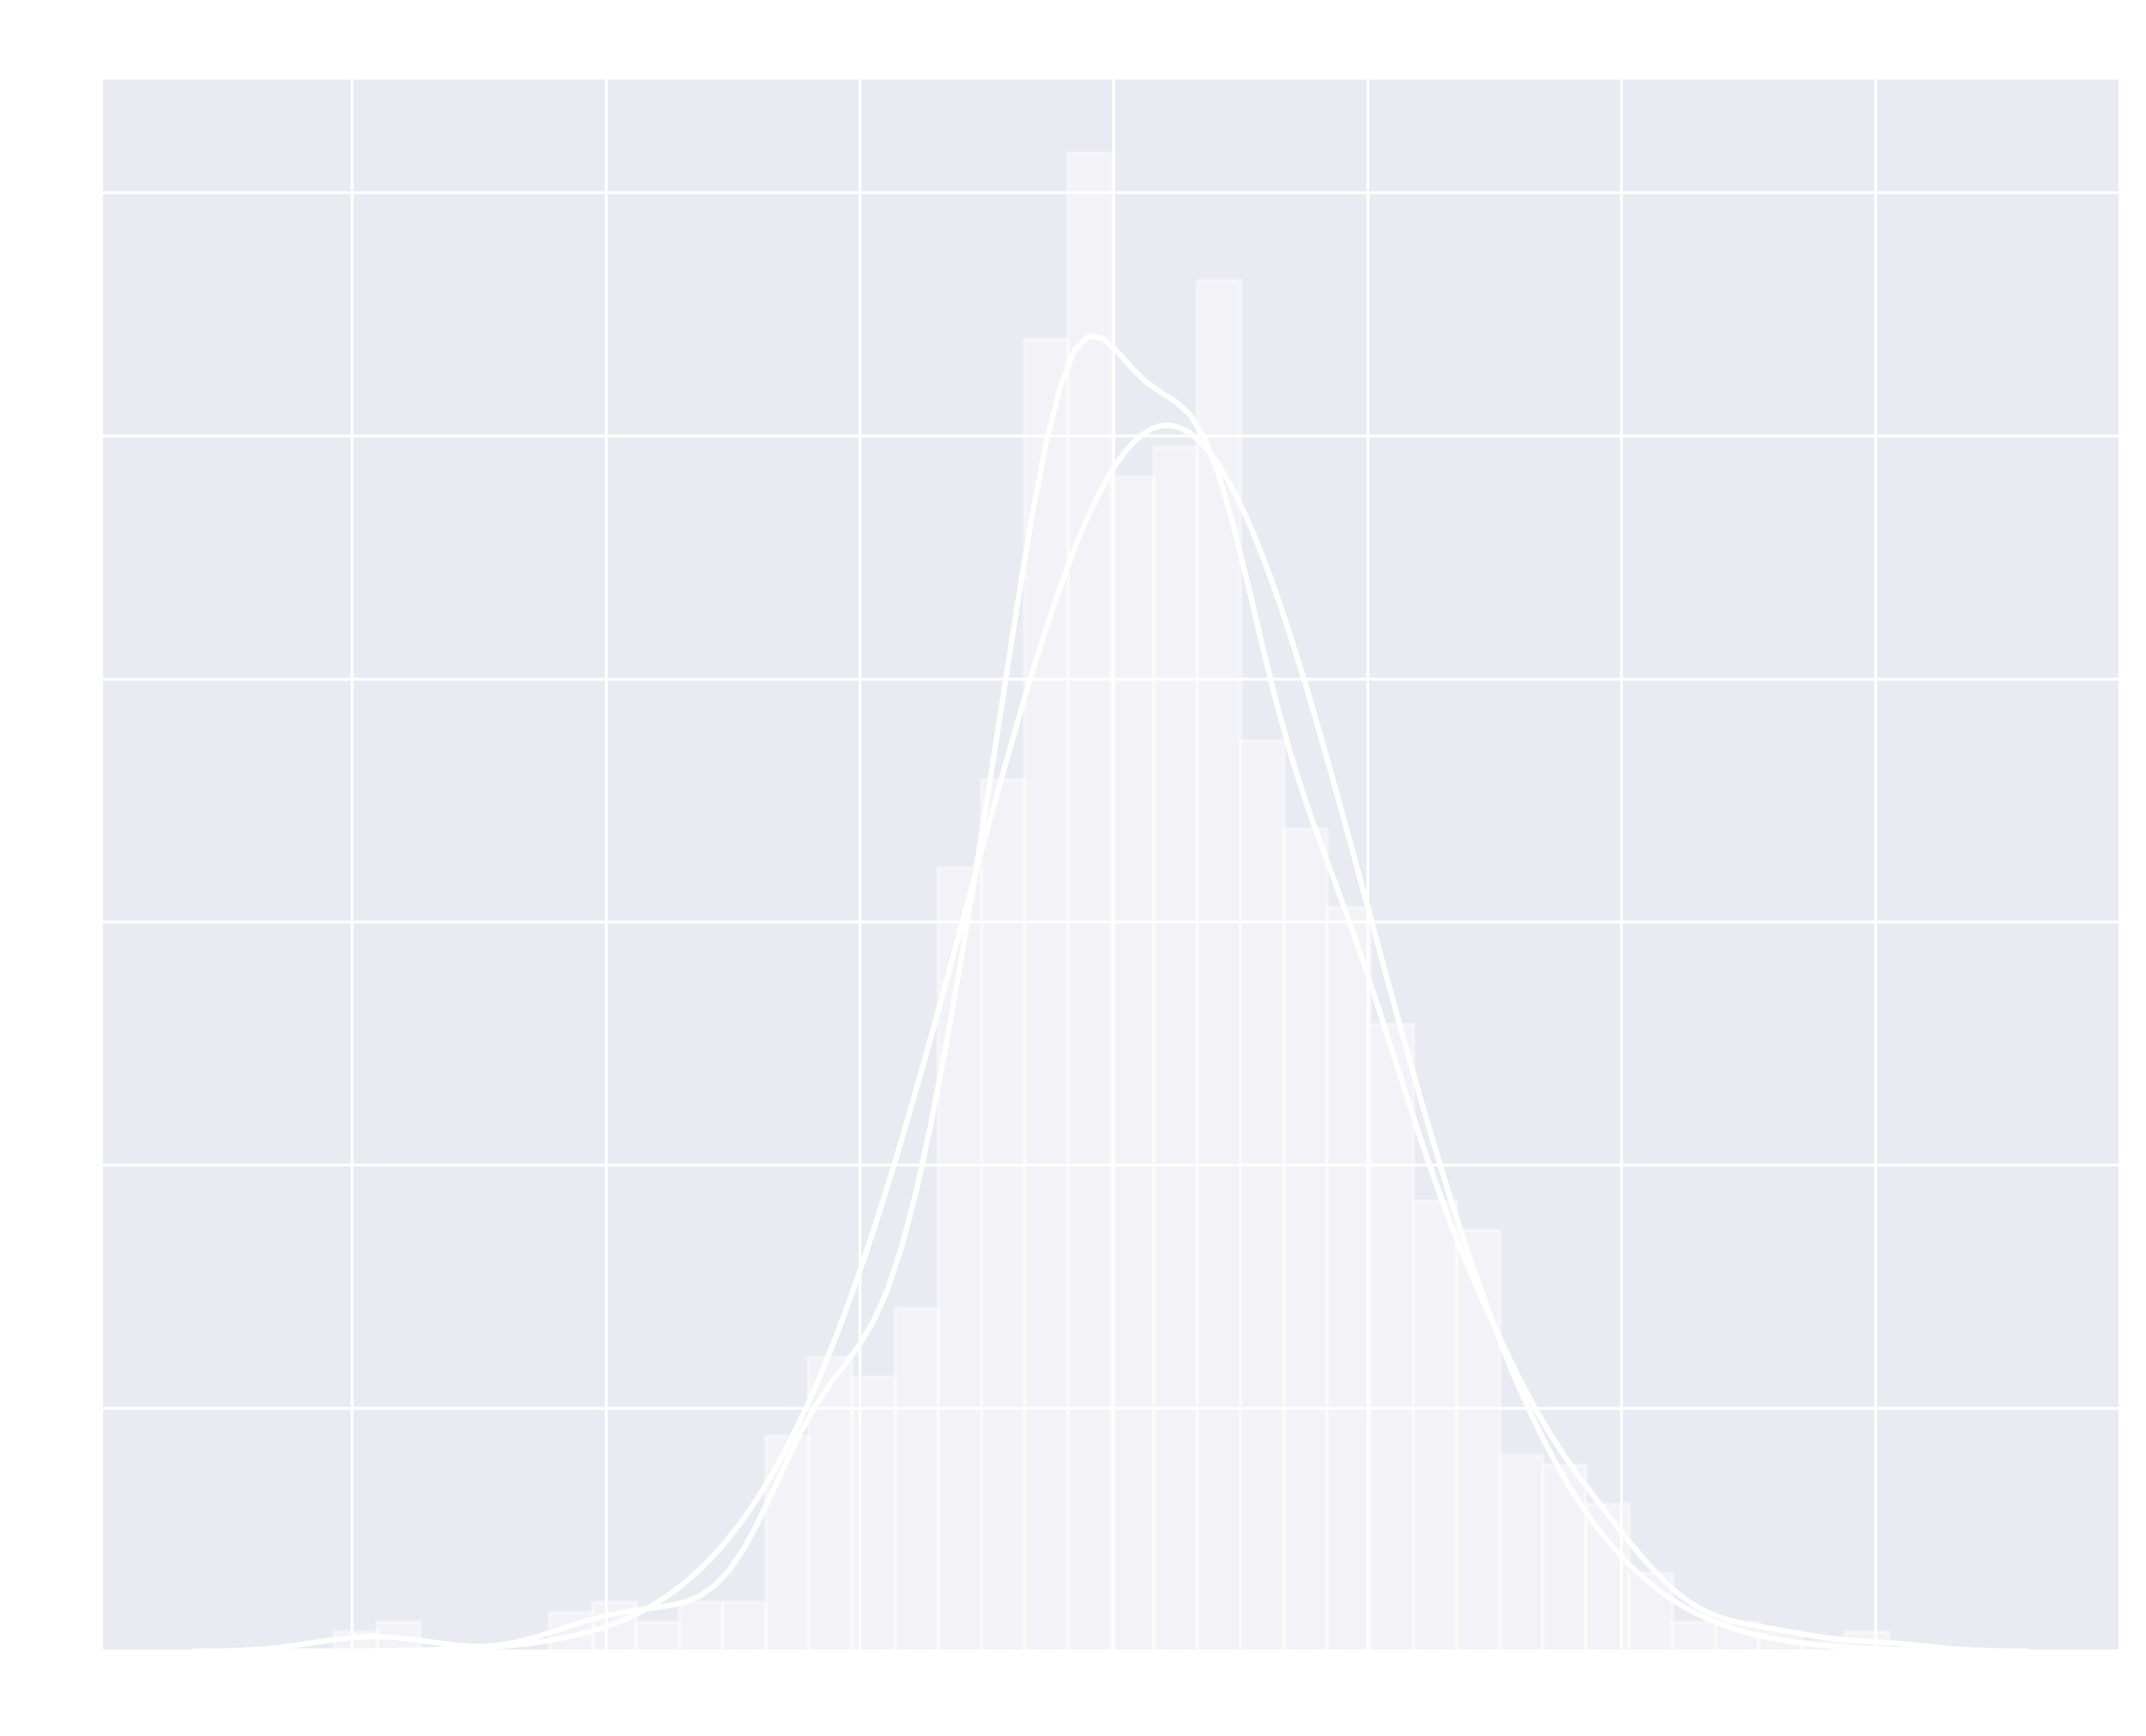

In [46]:
plt.subplots(figsize=(10,8),dpi = 500)
trans_var, lambda_var = stats.boxcox(train['SalePrice'].dropna()+1)
sns.distplot(trans_var , color="white", fit=stats.norm, fit_kws={"color":"white"});
plt.title('SalePrice Transformed', color="white")
plt.xlabel('')
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
plt.savefig('corrPlot.png',  format='png',transparent=True)

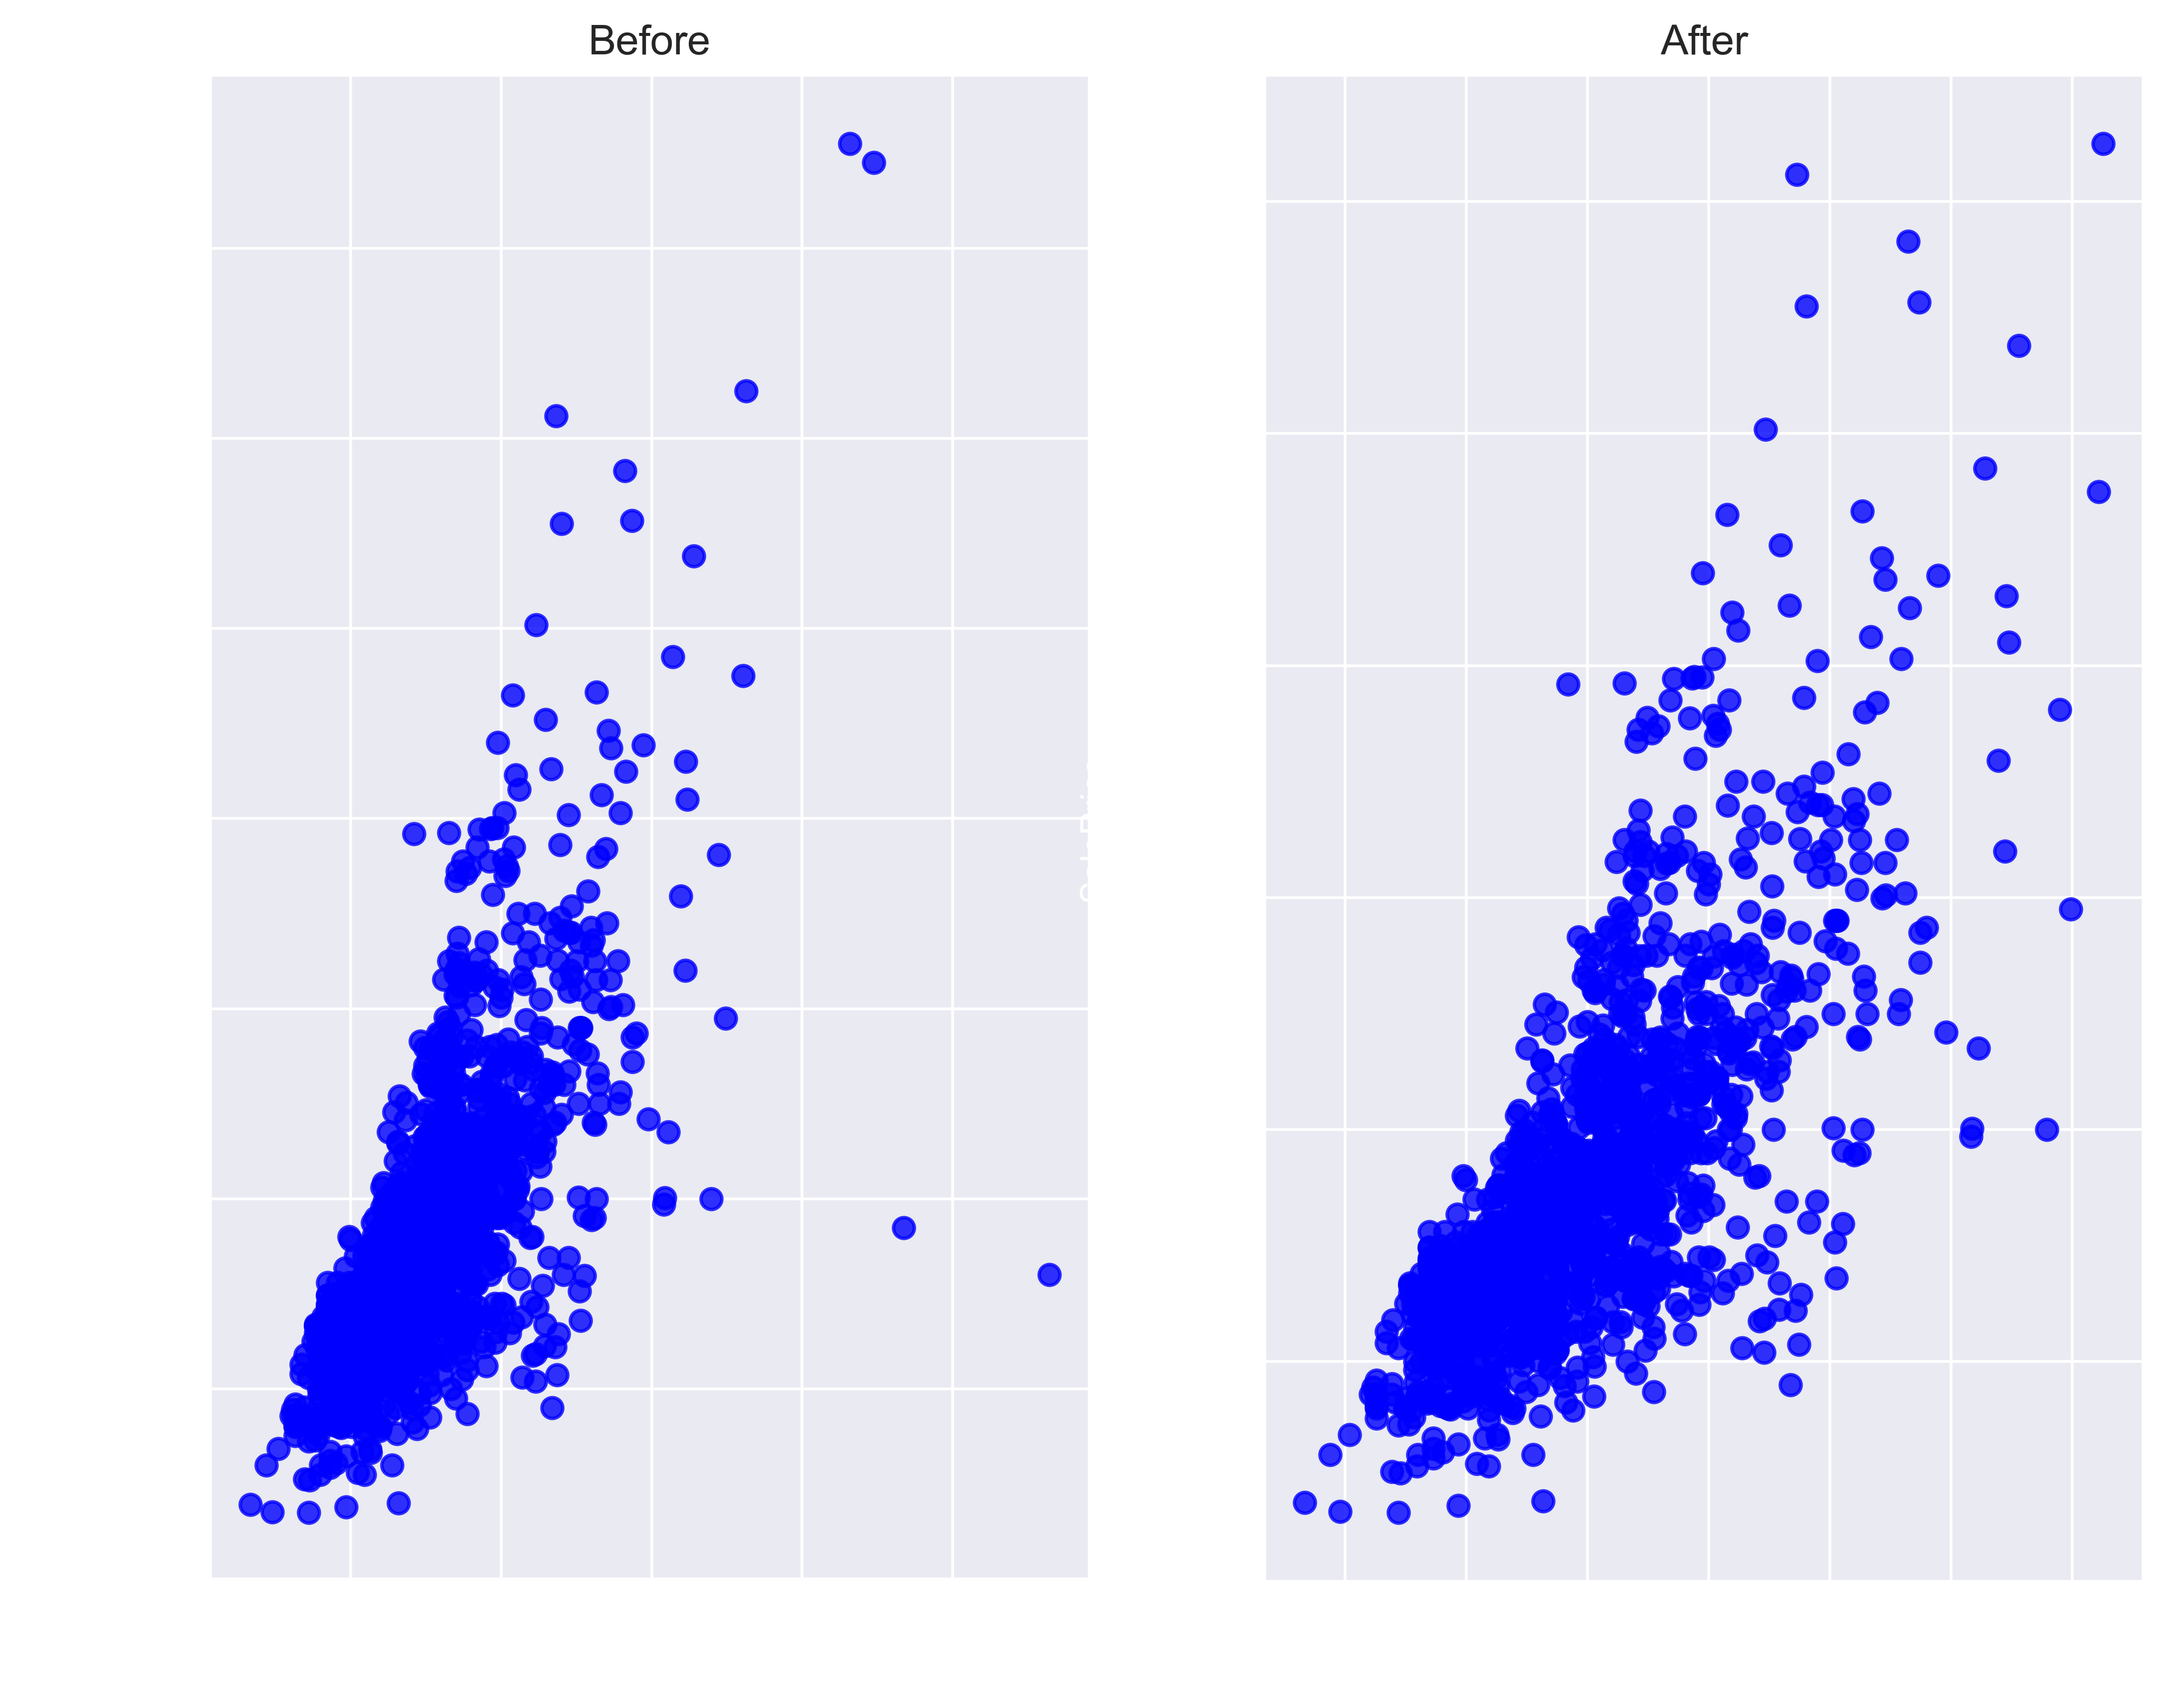

In [50]:
plt.subplots(figsize=(10,8),dpi = 500)

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'],color="blue", fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'],color="blue", fit_reg=False).set_title("After")

custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)

plt.savefig('corrPlot.png', format='png',transparent=True)

AttributeError: 'numpy.ndarray' object has no attribute 'title'

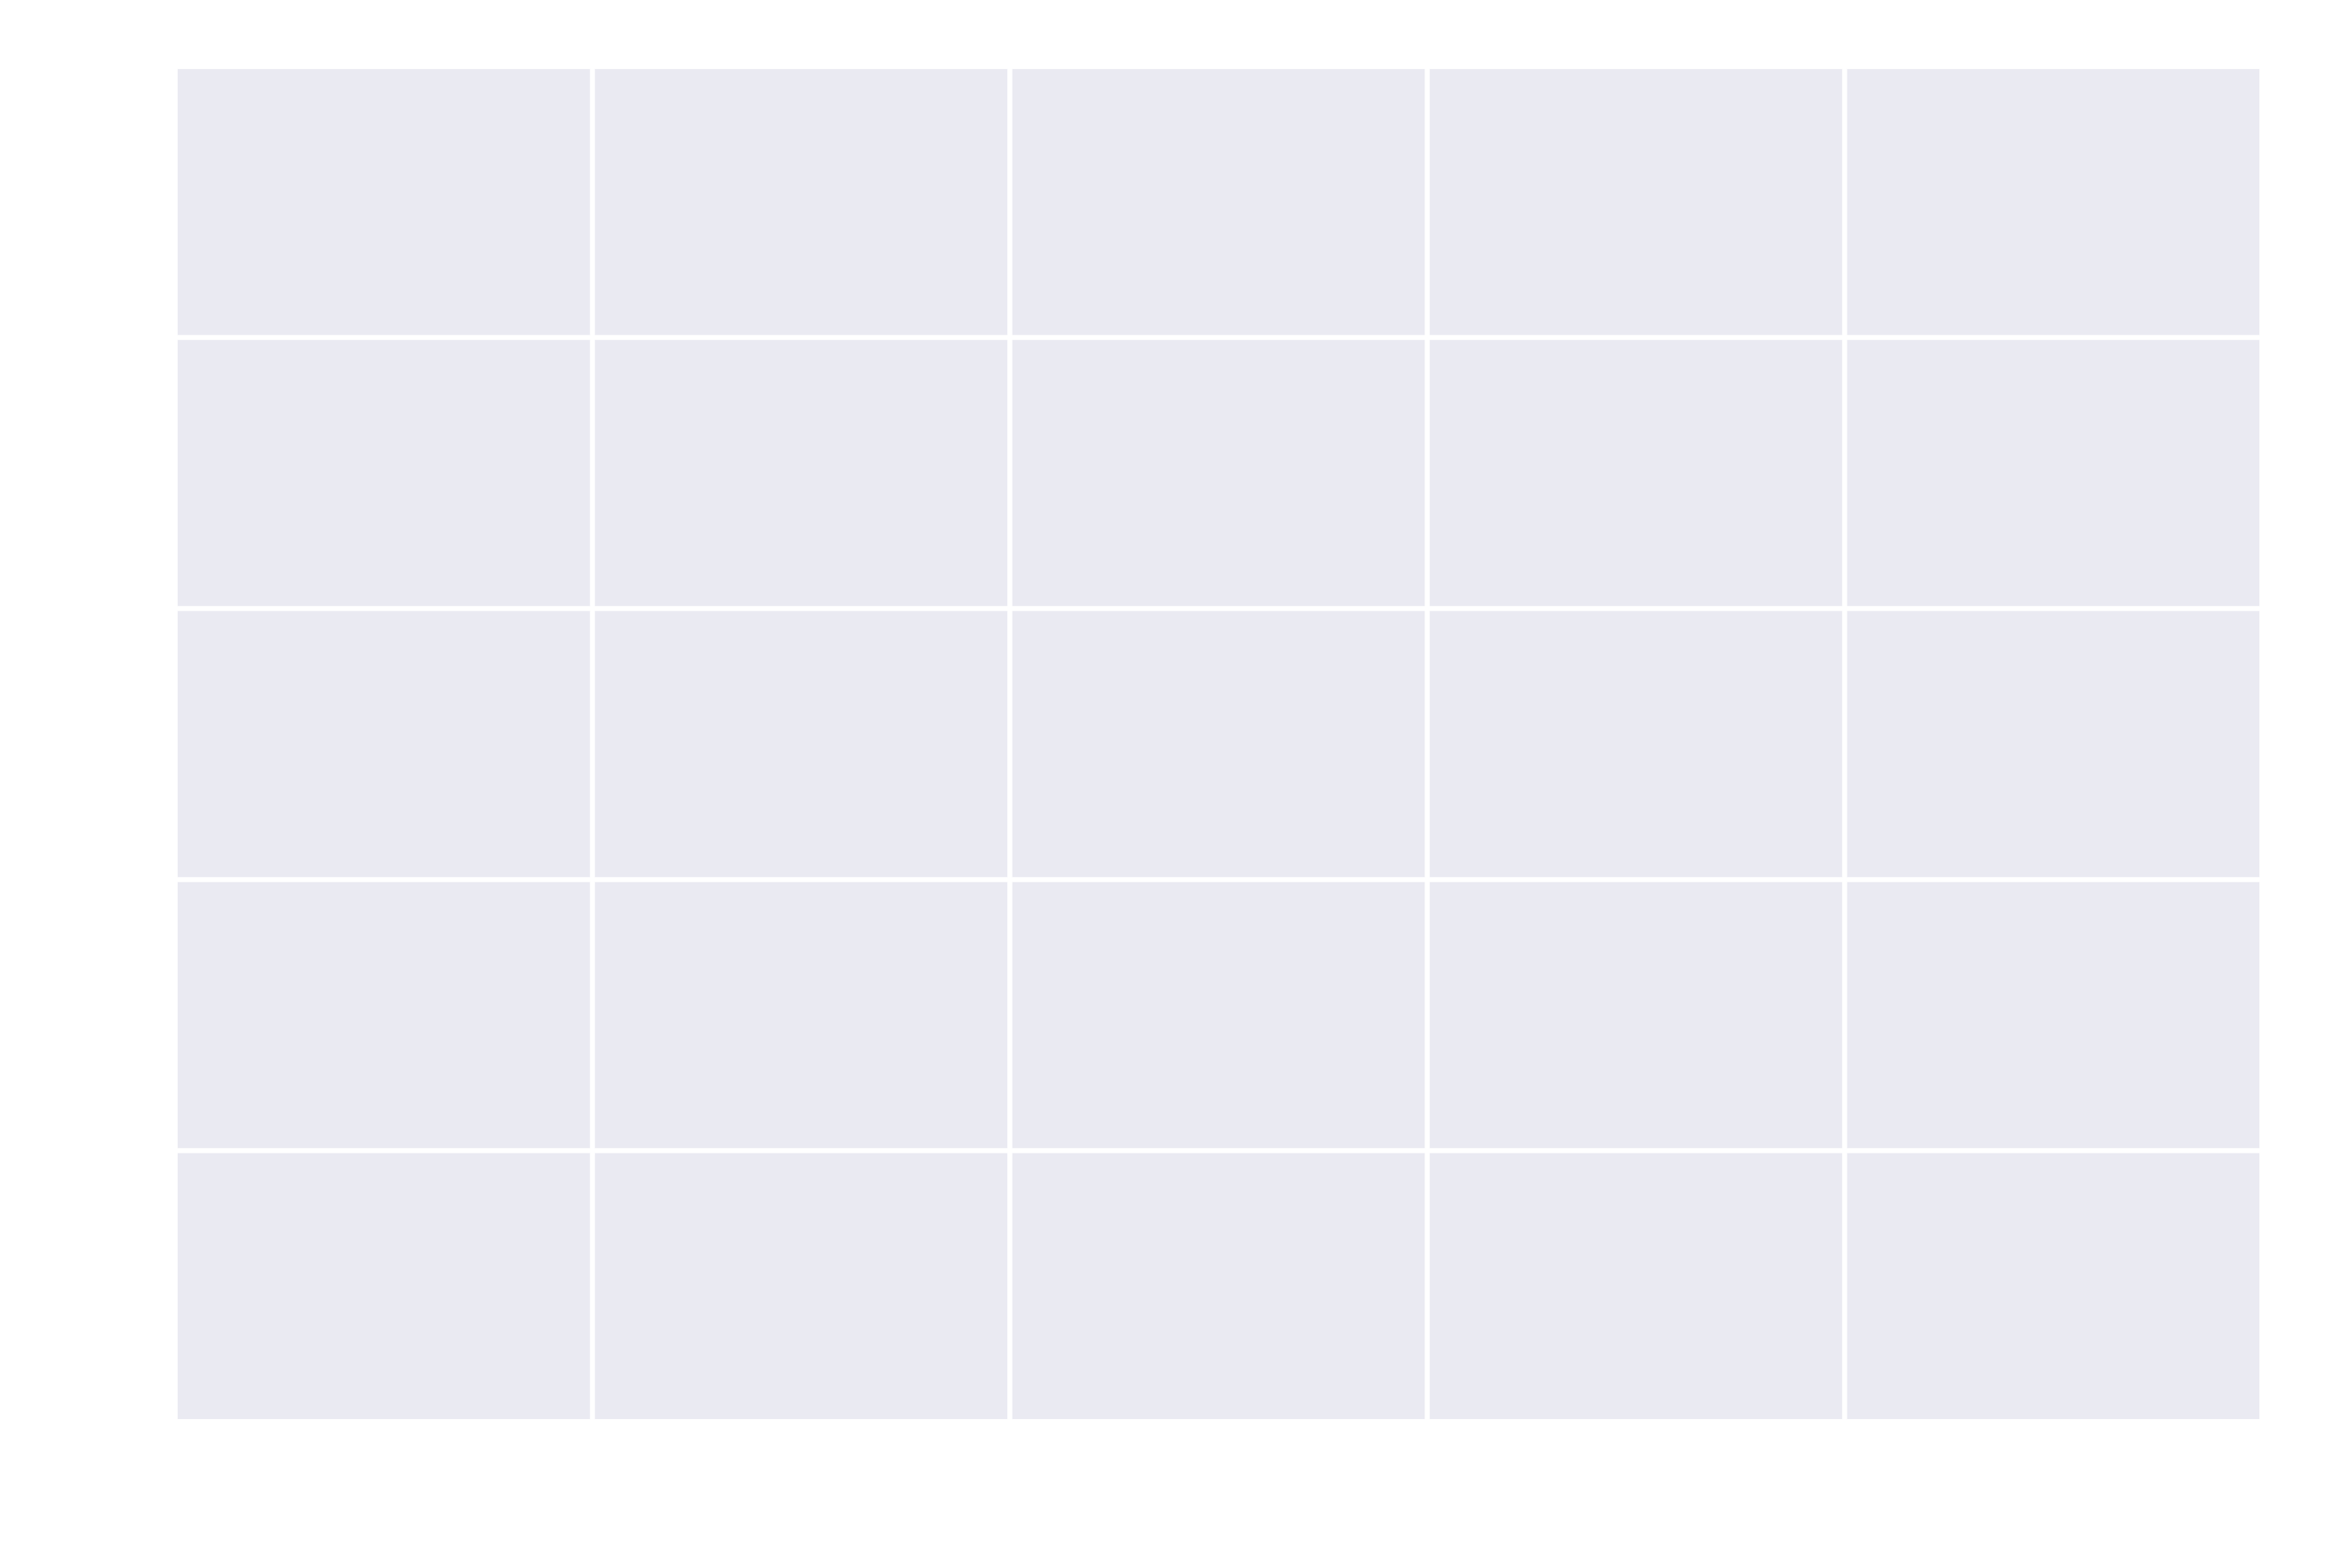

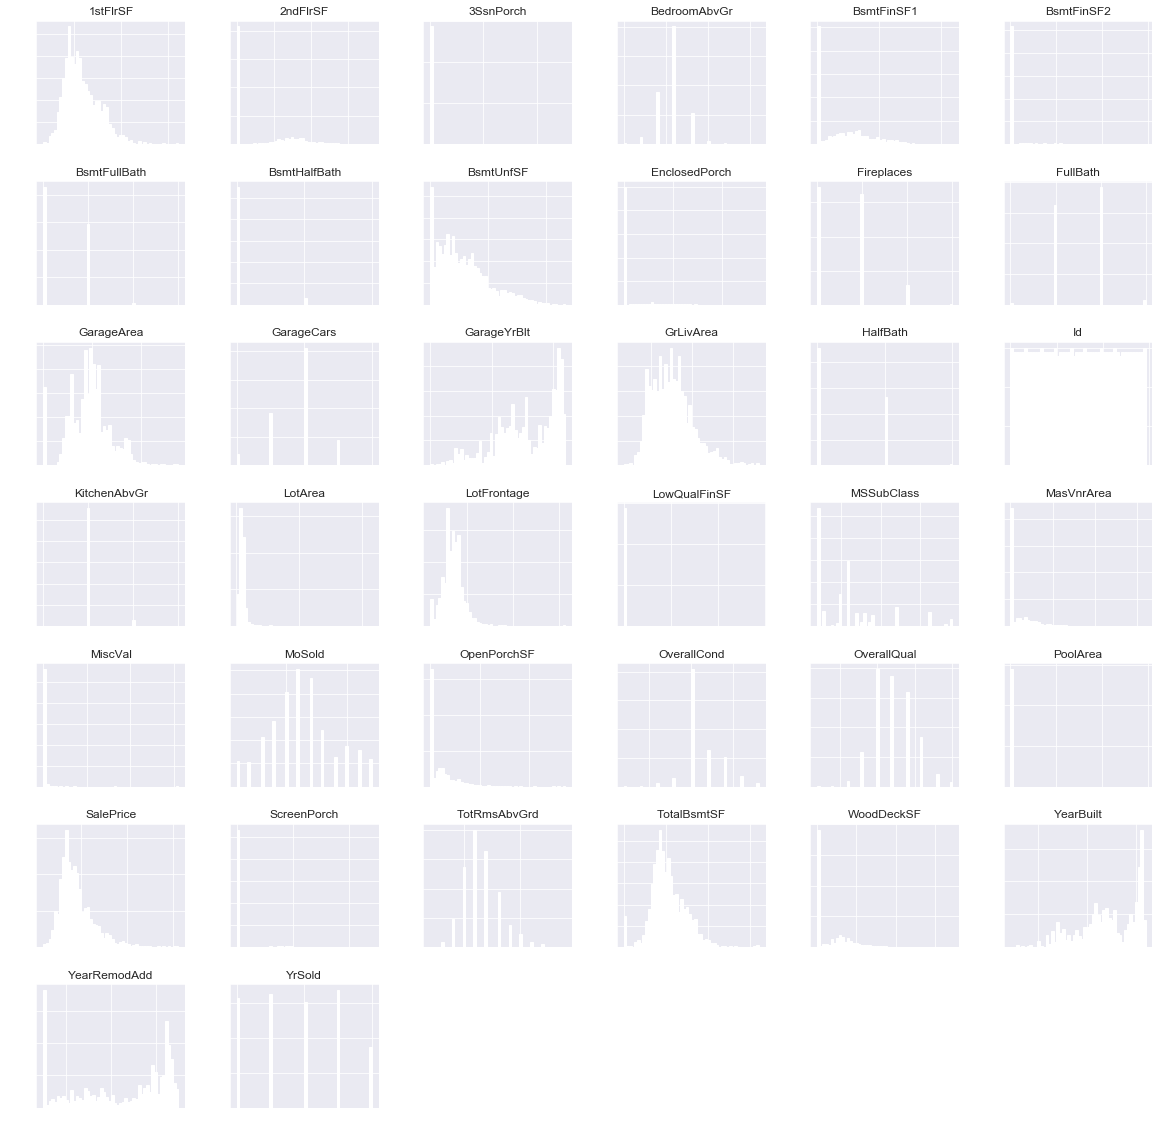

In [54]:
plt.subplots(dpi = 500)
a = train.hist(bins=50,figsize=(20,20), color="white")
a.title(color="white")
plt.savefig('fullNumericalHist.png', format='png',transparent=True)

In [56]:
# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

train_df = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/xiangwei/data/train_schrank.csv')

train_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000)].index)
train_df['GarageQuality'] = train_df['GarageQuality'].astype('int64')
train_df['GarageAge'] = train_df['GarageAge'].astype('int64')

catTrain = train_df.loc[:, train_df.dtypes == 'object']
list(catTrain.columns)

train_full = pd.get_dummies(train_df, 
                          columns=list(catTrain.columns), 
                          drop_first=True)

y = train_full['SalePrice']
y_ad = train_full['SalePriceAd']
X = train_full.drop(['SalePrice', 'SalePriceAd'], 1)
X.head()

My colours are ready! :)


,MSZoning,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.540963,65.0,19.212182,1.540963,0.0,7,2.055642,8.059126,1.820334,1.540963,...,0,0,0,0,1,0,0,0,1,0
1,1.540963,80.0,19.712205,1.540963,0.0,6,2.602594,0.000000,1.540963,1.540963,...,0,0,0,0,1,0,0,0,1,0
2,1.540963,68.0,20.347241,1.194318,0.0,7,2.055642,7.646538,1.820334,1.540963,...,0,0,0,0,1,0,0,0,1,0
3,1.540963,60.0,19.691553,1.194318,0.0,7,2.055642,0.000000,1.540963,1.540963,...,0,0,0,0,1,0,0,0,0,0
4,1.540963,84.0,21.325160,1.194318,0.0,8,2.055642,9.391827,1.820334,1.540963,...,0,0,0,0,1,0,0,0,1,0


In [60]:
import xgboost as xgb

model = xgb.XGBRegressor()
y_train = y
model.fit(X, y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:20]

# Visualise these with a barplot
plt.subplots(figsize=(30, 20),dpi = 500)
g = sns.barplot(y=X.columns[indices], x = model.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12, color="white")
g.set_ylabel("Features",fontsize=12, color="white")

g.tick_params(labelsize=12, color="white")
g.set_title("XGB feature importance", color="white");

plt.savefig('FeatureImportant.png', format='png',transparent=True)

### Feature Engineering


- **Convert conditions and qualities to ordinal values** : default=”gini”.
- **Missing value imputation**: default = None.
- **Remove outliers**: default = 2.
- **Adjust skewness**: default = 1.
- **New features**: The number of trees. default=100.
- **Standardization and normalization**
- **Remove unnecessary features**

Missing Completely at Random, MCAR, means there is no relationship between the missingness of the data and any values, observed or missing. Those missing data points are a random subset of the data. There is nothing systematic going on that makes some data more likely to be missing than others.

Missing at Random, MAR, means there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
Whether an observation is missing has nothing to do with the missing values, but it does have to do with the values of an individual’s observed variables. So, for example, if men are more likely to tell you their weight than women, weight is MAR.

Missing Not at Random, MNAR, means there is a relationship between the propensity of a value to be missing and its values. This is a case where the people with the lowest education are missing on education or the sickest people are most likely to drop out of the study.
For example, all of the missing value from the pool column is MNAR, since all missing value just mean the house does not have a pool.


Remove unnecessary features

To remove the multicollinearity issue, we drop a that has high correlation.

'Condition2', 'Alley', 'YearBuilt', 'YearRemodAdd', 
		'Exterior2nd', 'HouseStyle', 'MSSubClass', 'YearBuilt', 
		'YearRemodAdd', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
		'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'GarageCond', 
		'GarageQual', 'GarageYrBlt'

### Feature Importance


- **Selected by RandomForest** : default=”gini”.
- **Selected by XGBoost**: default = None.
- **Principle component analysis**: default = 2.

### Machine Learning Models


- **LASSO** : default=”gini”.
- **Ridge**: default = None.
- **ElasticNet**
- **Random Forest**
- **Gradient Boosting**
- **AdaBoosting**
- **XGBoosting**

### Stacking

- **Weights**
- **Results**


In [27]:
### replace the conditions and qualities with numbers: 'ExterQual', 'ExterCond, 'HeatingQC', 'KitchenQual', 'CentralAir', 'LotShape'
CondReplacement = {
    'ExterQual': 
        ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    ,
    'ExterCond': 
        ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    ,
    'HeatingQC': 
        ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    ,
    'KitchenQual': 
        ['Po', 'Fa', 'TA', 'Gd', 'Ex']
}

a = pd.DataFrame.from_dict(CondReplacement)
a.to_csv("benDick.csv")

In [58]:
dataset['SaleType'].value_counts()

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [15]:
def AddHPI(ameshpi, df, train = True):
    ameshpi['Qrtr'] = ameshpi['MoSold'].apply(lambda i : (i+2)//3)

    df['Qrtr'] = df['MoSold'].apply(lambda i:(i+2)//3)
    del ameshpi['MoSold']

    df_full = pd.merge(df, ameshpi,  how='left', on=['YrSold','Qrtr'])

    if train == True:
        df_full['SalePriceAd'] = (df_full['SalePrice']/(df_full['ATNHPIUS11180Q']/100))
        return df_full[['SalePrice', 'SalePriceAd']]

    else:
        return df_full
    
def HPIConversion(ameshpi, y_ad, test):
    '''
    this function takes the predicted values of adjusted SalePrice and output the predicted SalePrice
    '''
    #y_ad = np.exp(y_ad)
    df_full = AddHPI(ameshpi, test, train = False)
    df_full = pd.concat([df_full, y_ad], axis = 1)
    df_full['SalePrice'] = df_full['0']*(df_full['ATNHPIUS11180Q']/100)
    return df_full[['SalePrice']]

In [26]:
y_xgboost =  pd.read_csv('data/y_xgboost.csv')
y_xgboost.drop(['Unnamed: 0'], axis = 1,  inplace = True)
y_xgboost = np.exp(y_xgboost)
y_xgboost.to_csv(r'./data/saleprice_xgb.csv', index = False)

In [27]:
y_rf =  pd.read_csv('data/y_rf.csv')
y_rf.drop(['Unnamed: 0'], axis = 1,  inplace = True)
y_rf = np.exp(y_rf)
y_rf.to_csv(r'./data/saleprice_rf.csv', index = False)

In [31]:
y_xgboost =  pd.read_csv('data/xgboost.csv')
y_xgboost.drop(['Unnamed: 0'], axis = 1,  inplace = True)
y_xgboost = np.exp(y_xgboost)
y_xgboost.to_csv(r'./data/saleprice_xgb.csv', index = False)

In [35]:
y_xgboost =  pd.read_csv('data/xgBoost3.csv')
y_xgboost.drop(['Unnamed: 0'], axis = 1,  inplace = True)
y_xgboost = np.exp(y_xgboost)
y_xgboost.to_csv(r'./data/saleprice_xgb3.csv', index = False)

In [ ]:
y_xgboost =  pd.read_csv('data/y_gsearch.csv')
y_xgboost.drop(['Unnamed: 0'], axis = 1,  inplace = True)
y_xgboost = np.exp(y_xgboost)
y_xgboost.to_csv(r'./data/saleprice_xgb1.csv', index = False)

In [36]:
y_elastic =  pd.read_csv('data/elastic7.csv')
y_elastic.drop(['Unnamed: 0'], axis = 1,  inplace = True)
y_elastic = np.exp(y_elastic)
y_elastic.to_csv(r'./data/saleprice_elastic.csv', index = False)

In [ ]:
print(train_dummified.shape)
print(train.shape)
print(test.shape)
print(test_dummified.shape)

In [ ]:
def Standardize(df):
    '''
    this function will standardize all the numeric variables including the ordinal variables
    '''
    ### PCA Analysis
    df_num = df.loc[:, df.dtypes != 'object']
    df_cat = df.loc[:, df.dtypes == 'object']
    df_num = df_num.astype('float64')

    # Standardizing the features
    df_num_scaled = pd.DataFrame(StandardScaler().fit_transform(df_num), columns = df_num.columns)   # Use StandardScaler to help you standardize the features

    return pd.concat([df_num_scaled, df_cat], axis = 1)

In [ ]:
train = Standardize(train_dummified)

In [ ]:
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(df),columns = df.columns)

In [ ]:
df_num = train_dummified.loc[:, train_dummified.dtypes != 'object']
df_cat = train_dummified.loc[:, train_dummified.dtypes == 'object']

In [ ]:
df_num = df_num.astype('float64')

In [ ]:
df_num = StandardScaler().fit_transform(df_num)

In [ ]:
type(df_cat)

In [ ]:
pd.concat([df_num,df_cat], axis = 1)

In [ ]:
type(df_num)

In [ ]:
train.shape

In [ ]:
train_dummified.shape

In [ ]:
idx_num = df.dtypes[df.dtypes != "object"].index

# Check how skewed they are
skew_num = df[idx_num].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewness = skew_num[abs(skew_num) > 0.5]

df_full = df.copy()
for feat in skewness.index:
    df_full[feat] = boxcox1p(df_full[feat], 0.15)

In [ ]:
df[idx_num]

In [ ]:
df[idx_num].apply(lambda x: stats.skew(x.dropna()))

In [ ]:
# Check how skewed they are
skew_num = df[idx_num].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewness = skew_num[abs(skew_num) > 0.5]
skew_num

In [ ]:

# Check how skewed they are
skew_num = df[idx_num].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewness = skew_num[abs(skew_num) > 0.5]
skew_num

df_full = df.copy()
for feat in skewness.index:
    df_full[feat] = boxcox1p(df_full[feat], 0.15)

In [ ]:
df_full

In [ ]:
df.shape

In [ ]:
skewness.index

In [28]:
range(2, 10, 3)

range(2, 10, 3)

In [29]:
range(2, 10, 2)

range(2, 10, 2)

In [30]:
print(range(2, 10, 2))

range(2, 10, 2)


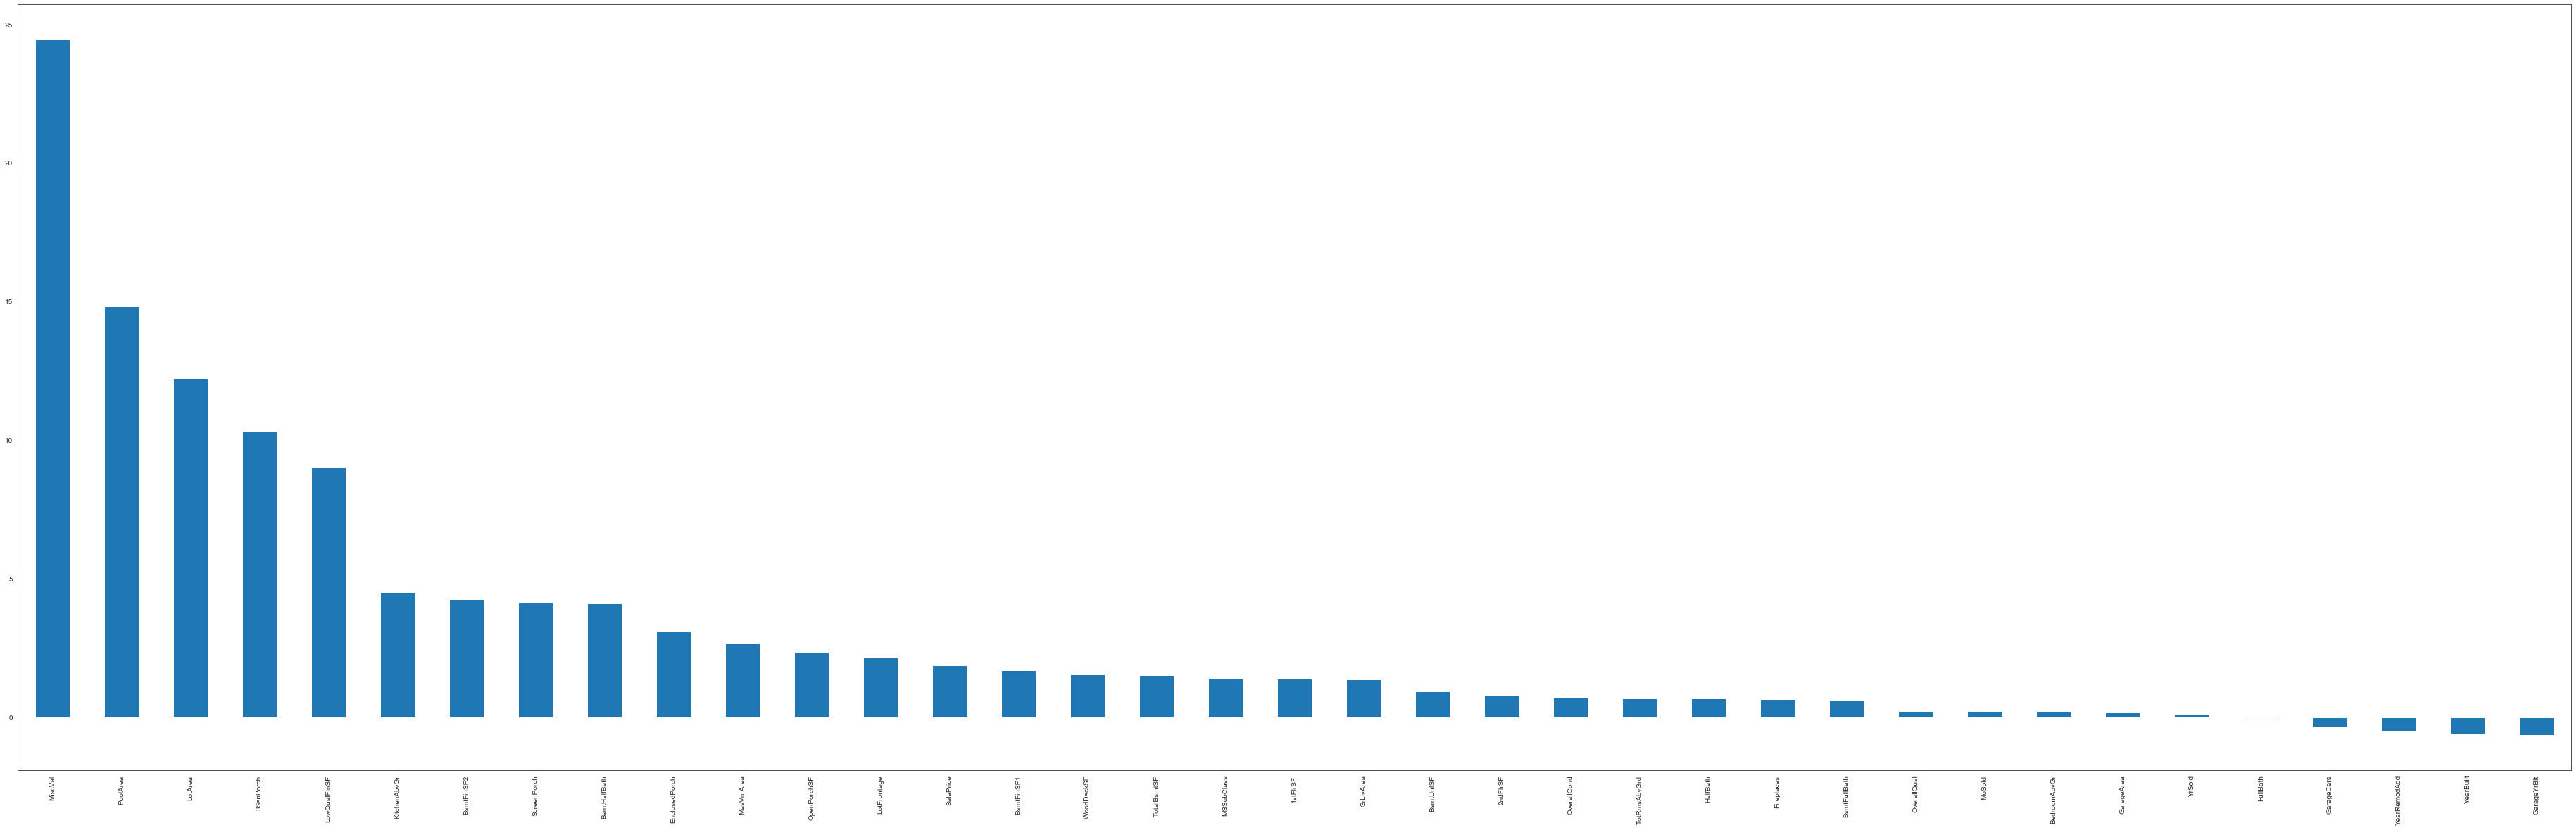

In [29]:
# numTrain = train_full2.loc[:, train_full2.dtypes != 'object'].index #from above
numTrainidx = train.dtypes[train.dtypes != "object"].index
numTrainidx

# Check how skewed they are
numTrainskew = train[numTrainidx].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
numTrainskew
plt.subplots(figsize =(65, 20))
numTrainskew.plot(kind='bar');